# Machine Learning - Task F

**Part of IAFIG-RMS *Python for Bioimage Analysis* Course.**

*M Kundegorski*

2019-12-13

In this task you will classify toy data of 'blobs' using Histogram of Gradient (HoG) features and two classifiers: Support Vector Machines (SVM) and Random Forests.

We will use the same data from the logistic regression we did in Task B so you can compare the quality of the results.

## The Task (c.f. Task B)

In an experiment we were able to image lots of different types of cells. These cells are sparse so we were easily able to segment them, find their bounding box and create a database of images each containing a single cell. We then convinced a PhD student to go through and manually categorise our cells. We want to use regression to be able to automatically categorise new, unlabelled cells from future experiments.

To do this, we will:
1. Calculate Histogram of Gradient (HoG) features for our images.
2. Use Support Vector Machines (SVM) for classification.
3. Use training data to fit the regression and test data to check how well our model works.
4. Advanced: Use Random Forest for classification.
5. Advanced: Use visual inspection to understand what might cause problems for classification models.

,class,raw_data
count,1200,1200
unique,11,1200
top,7,"[[14, 17, 14, 16, 15, 16, 15, 16, 13, 18, 14, ..."
freq,140,1


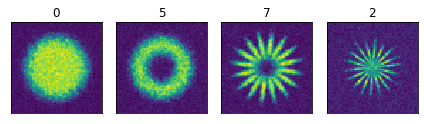

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2  # OpenCV - we will use their HoG feature descriptor
from sklearn import model_selection

# Utils is a custom module written to simplify these tutorials
# You do not need to understand these codes for this practical
from utils.practice_data import generateBlobsData  # this loads data into a DataFrame
from utils.practice_data import showBlobs  # this allows quick visualisation of the data

# Generate a pandas DataFrame of data
# with a column 'class', i.e. the categry a cell belongs to,
# and a column 'raw_data' which hold the NumPy array/image
imageDir = './assets/simple_blobs/'
number_of_samples = 1200
image_size = 64  # in pixels
number_of_classes = 2 #2-6 - normal blobs. 7-11 more difficult
problem = generateBlobsData(imageDir, number_of_classes, number_of_samples, image_size, noiseSize=20)

#Visualise the data
display(problem.loc[:,'class'].describe())  # describe classes; note the number of unique classes
showBlobs(problem.sample(10))  # plots the images with their class above.

## Task F.1

In [2]:

x=np.stack(problem['raw_data']) #Turn pandas series to numpy array
y=problem['class'].values.reshape(-1,1).flatten().astype(int)


In [ ]:
# In this task we will use HoG descriptor from OpenCV. You can find documentation https://docs.opencv.org/4.1.2/d5/d33/structcv_1_1HOGDescriptor.html#a5c8e8ce0578512fe80493ed3ed88ca83
winSize = (32,32)
blockSize = (8,8)
blockStride = (8,8)
cellSize = (4,4)
bins = 9
hog_cv = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, bins)

hogdata=[]
for iii in range(0,len(x)):
    descriptor = hog_cv.compute(x[iii,:,:])
    hogdata.append(descriptor)

x_hog = np.array(hogdata)
x_hog = x_hog.reshape(x_hog.shape[0],-1)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_hog, y, test_size=0.2, random_state=0)


In [5]:
# Fidn documentation of SVM at https://docs.opencv.org/4.1.2/d1/d2d/classcv_1_1ml_1_1SVM.html
svm = cv2.ml.SVM_create()

#kernel choice is important
svm.setKernel(cv2.ml.SVM_LINEAR)

#You can try polynomial kernel with specified degree
#svm.setKernel(cv2.ml.SVM_POLY)
#svm.setDegree(4)

#Is gaussian Kernel suitable for this task?
#svm.setKernel(cv2.ml.SVM_LINEAR)

svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(1.005)
svm.setGamma(10.383)
svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
result_svm = svm.predict(x_test)[1].flatten()
mask = result_svm==y_test
correct = np.count_nonzero(mask)
print('Correct classification of SVM classifier: {}'.format(correct*100.0/y_test.size))
#svm.save('svm_data.dat') # you can save classifiers and load them to avoid waiting for retraining when comparing different classifiers

#setting trees
#Documentation of Random Forest: https://docs.opencv.org/4.1.2/d0/d65/classcv_1_1ml_1_1RTrees.html#a39dae109b823a296bb7077d99970e664
rf = cv2.ml.RTrees_create()
rf.setTermCriteria(( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 10 ))
rf.train(x_train, cv2.ml.ROW_SAMPLE, y_train);

result_rf = rf.predict(x_test)[1].flatten()
mask = result_rf==y_test
correct = np.count_nonzero(mask)
print('Correct classification of Random Forest classifier: {}'.format(correct*100.0/y_test.size))

Correct classification of SVM classifier: 76.25
Correct classification of Random Forest classifier: 46.25


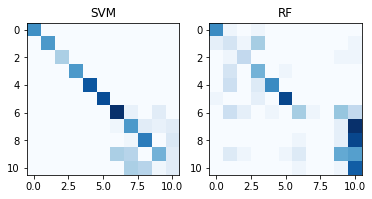

In [6]:
from sklearn.metrics import confusion_matrix



f, axes = plt.subplots(1,2)
ax1, ax2 = axes.flatten()
ax1.imshow(confusion_matrix(y_test,result_svm),cmap=plt.cm.Blues)
ax1.set_title('SVM')
ax2.imshow(confusion_matrix(y_test,result_rf),cmap=plt.cm.Blues)
ax2.set_title('RF')
plt.show()


In [7]:
#https://www.datacamp.com/community/tutorials/random-forests-classifier-python
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

In [8]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6875


In [9]:

#You can also analyse results of each class
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, result_svm)

array([[[223,   0],
        [  0,  17]],

       [[224,   0],
        [  0,  16]],

       [[231,   0],
        [  0,   9]],

       [[224,   0],
        [  0,  16]],

       [[217,   0],
        [  0,  23]],

       [[216,   0],
        [  0,  24]],

       [[198,  10],
        [  5,  27]],

       [[195,  20],
        [  9,  16]],

       [[205,  11],
        [  5,  19]],

       [[201,   6],
        [ 20,  13]],

       [[209,  10],
        [ 18,   3]]])